Motor Current Signature Analysis (MCSA) is a technique used to determine the operating condition of induction motors without interrupting production. Motor current signature analysis is that it is sensing an electrical signal that contains current components. MCSA detect the faults at an early stage and avoid the damage and complete failure of the motor.


# Importing necessary Libraries

In [54]:
import os
import glob

#Data manupulation and handling
import numpy as np
import pandas as pd
from scipy import signal

# Data Visulisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
%matplotlib inline

# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report


#warning filter library
import warnings
warnings.filterwarnings('ignore')


In [50]:
folder_path = '/dataset'
file_list = glob.glob(folder_path + "/*.txt")

data_collected = []
for i in range(len(file_list)):
   readings = np.genfromtxt(file_list[i], delimiter=',', dtype=int)[:-1]
   data_collected.append(readings)
current_measurements = np.concatenate(data_collected)
print('Total Number of current readings count : ', len(current_measurements))

Total Number of current readings count :  60000


There are several methods which able to detect failures, starting with the most basic (FFT), to the most complex (Gaussian Mixture Model). These have the advantage of being able to be re-used with minor modifications on different data streams, and don't require a lot of known previously classified data

# FFT (Fast Fourier Transform) 



Streaming output truncated to the last 5000 lines.
1702.0   61.84412671924276
1706.0   51.23034967714791
1711.0   58.71239026230224
1715.0   63.48602112855
1720.0   59.17065701982252
1723.0   49.86161661138863
1728.0   65.77628918206317
1733.0   61.425948339648784
1737.0   66.42458747583001
1739.0   47.72733555910509
1742.0   59.75318491667693
1746.0   54.1005863670046
1751.0   64.63994676032273
1754.0   62.77720605495471
1759.0   56.78114477630549
1763.0   64.48493548325537
1768.0   58.34490970938456
1770.0   51.50314226382174
1775.0   54.79243360148104
1780.0   70.48103502685858
1785.0   70.00532875085676
1789.0   65.8211819813839
1794.0   65.14975509697678
1799.0   58.67639377322682
1804.0   46.254693479524114
1808.0   60.8920651340974
1811.0   58.911742129998686
1815.0   69.57533003690274
1820.0   59.44679915651304
1827.0   42.13667169924824
1829.0   37.921658737141215
1832.0   57.48701933519586
1834.0   59.505187750491885
1837.0   58.17196495599103
1840.0   55.15227753263466
1846.

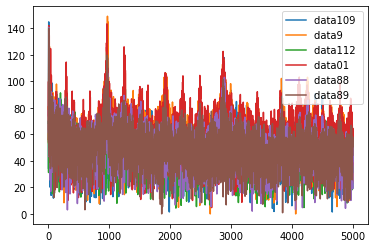

In [51]:
print('file_list : ', file_list)
# Make time array

current_array = []
for i in range(len(file_list)):
  print(i)
  timeTrain = np.genfromtxt(file_list[i], delimiter=',', dtype=int)[:-1]
  meanTrain = np.average(timeTrain)
  current_array.append(timeTrain - meanTrain)

print('current_array : ', current_array)

def makeData(time):
    # welch transform
    x1, y1 = signal.welch(time, 10000, nperseg=65535/2)
    # decibel conversion
    y1=20*np.log10(y1)
    # give offset
    y1 = y1 + 100
    # find max and divide by max, then square the value to reduce noise
    maxAmp = max(y1)
    y2 = y1/maxAmp
    y2 = np.square(y2)
    y2 = y2*maxAmp
    # global frequency
    # frequency = x1
    return x1, y2

xx = {}
yy = {}

for i in range(len(file_list)):
  xx[i], yy[i] = makeData(current_array[i])
print('xx : ', xx)
print('yy : ', yy)


def spikes(x, y, label = " "):
    print("")
    print("Data is", label)
    f = x.tolist()
    mag = y.tolist()
    for index, value in enumerate(mag):
        if index > 1 and index < (len(mag) - 1) and (mag[index] > mag[index+1]) and (mag[index] > mag[index - 1]) and (mag[index] > 10):
            print(str(f[index]) + "   " + str(mag[index]))

# Data from Multiple files 
for i in range(len(file_list)):
  file_name = file_list[i].split('/')[-1].replace('.txt', ' ')
  spikes(xx[i], yy[i], label = file_name)

  plt.plot(xx[i], yy[i], label = file_name)


plt.legend()
plt.show()


# SVM (Support Vector Machine)

**One-class SVM** is a variation of the SVM that can be used in an unsupervised setting for anomaly detection. Where instead of hyperplane to separate the classes (+ and -ve) draw boundry around data points to find the outliers/anomaly. Outside border to be anomalies.    

In [52]:
# Exclding last file to use as Test Data. Remaining data will be Training data

# Make train array 
train_data_collected = []
for i in range(len(file_list)-1):
   readings = np.genfromtxt(file_list[i], delimiter=',', dtype=int)[:-1]
   train_data_collected.append(readings)
current_measurements_train = np.concatenate(train_data_collected)
meanTrain = np.average(current_measurements_train)
current_measurements_train = current_measurements_train - meanTrain

EM_train = current_measurements_train

print('Total Number of current readings train count : ', len(current_measurements_train))

# Make test array 
test_data_collected = np.genfromtxt(file_list[len(file_list)-1], delimiter=',', dtype=int)[:-1]
current_measurements_test = test_data_collected
print('Total Number of current readings Test count : ', len(current_measurements_test))
PR_test = current_measurements_test

def makeData(current):
    # welch transform
    x1, y1 = signal.welch(current, 10000, nperseg=len(current)/2)
    # decibel conversion
    y1=20*np.log10(y1)
    # give offset
    y1 = y1 + 100
    # find max and divide by max, then square the value to reduce noise
    maxAmp = max(y1)
    y2 = y1/maxAmp
    y2 = np.square(y2)
    y2 = y2*maxAmp
    # global frequency
    # frequency = x1
    return x1, y2

freq_train, amp_train = makeData(EM_train)
X_Train = np.vstack((freq_train, amp_train)).T

freq_test, amp_test = makeData(PR_test)
X_Test = np.vstack((freq_test, amp_test)).T

y_train = np.full((len(amp_train)), -1, dtype=int)
y_test = np.full((len(amp_test)), -1, dtype=int)

# print('amp_train  :', amp_train)
# print('amp_test  :', amp_test)

def calculate_y(feature, target, threshold=110):
  for index, val in enumerate(feature):
    if val < threshold:
        target[index] = 1
    else:
        target[index] = -1

calculate_y(amp_train, y_train, 110)
calculate_y(amp_test, y_test, 110)

# Train One-Class Support Vector Machine (SVM) Model
one_class_svm = OneClassSVM(nu=0.1, kernel="poly", gamma=0.1).fit(X_Train)

# Predict the anomalies
prediction  = one_class_svm.predict(X_Test)

# Check the model performance
print(classification_report(y_test, prediction))

Total Number of current readings train count :  50000
Total Number of current readings Test count :  10000
              precision    recall  f1-score   support

          -1       0.01      0.67      0.02         3
           1       1.00      0.90      0.95      2498

    accuracy                           0.90      2501
   macro avg       0.50      0.78      0.48      2501
weighted avg       1.00      0.90      0.95      2501



## Customized prediction with changing threshold value

In [53]:
# Increases threshold value 

calculate_y(amp_train, y_train, 115)
calculate_y(amp_test, y_test, 115)

# Predict the anomalies
prediction  = one_class_svm.predict(X_Test)
print('prediction :', prediction)
print('y_test :', y_test )
# Check the model performance
print(classification_report(y_test, prediction))

prediction : [-1 -1 -1 ...  1  1  1]
y_test : [ 1  1 -1 ...  1  1  1]
              precision    recall  f1-score   support

          -1       0.01      1.00      0.02         2
           1       1.00      0.90      0.95      2499

    accuracy                           0.90      2501
   macro avg       0.50      0.95      0.48      2501
weighted avg       1.00      0.90      0.95      2501



Recall 0.67 when threshold value 110 (y-axis) amp after scaling(actual 220) . Recall get increases to 1.00 on increases the threshold 115.